# CSM encoding - Generating CSM data from an audio file  

The second half of this notebook does a re-synthesis of the voice data from the generated CMS data. That portion is identical with the `csm_synthesis.ipynb`.  

In [35]:
import os
import math

import librosa
import librosa.display

import numpy as np

## Read input audio file

In [16]:
input_file = './resources/apollo11_launch.wav'

waveform, sample_rate = librosa.load(input_file, sr=None, mono=True)
waveform = librosa.to_mono(waveform)
waveform = librosa.resample(waveform, orig_sr=sample_rate, target_sr=44100)

print(f'{waveform.shape}, {waveform.shape[0]/44100} sec')

(1113906,), 25.258639455782312 sec


## Apply STFT (short term Fourier transform)

In [26]:
n_fft = int(44100 * 40e-3)        # STFT window size == 40ms
hop_length = n_fft // 4           # hop_length == 40ms/4 == 10ms
D = librosa.stft(waveform, n_fft=n_fft, hop_length=hop_length)
S, phase = librosa.magphase(D)    # convert complex number to power + phase
Sdb = librosa.amplitude_to_db(S)  # convert power (amplitude) to dB
print(Sdb.shape)

(883, 2526)


## Display spectrogram of input audio data

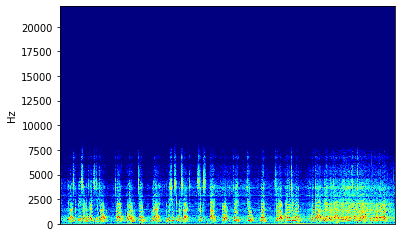

In [27]:
librosa.display.specshow(Sdb, sr=44100, y_axis='hz', cmap='jet')

# Display Fourier transformed data of a moment (linear power)

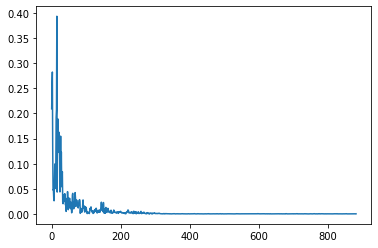

In [28]:
import matplotlib.pyplot as plt
a = S[:,800]
plt.plot(a)
plt.show()

### Define utility functions to find out the peaks of the power from the Fourier transformed data

In [29]:
def smooth(vec):
    tmp_vec = np.concatenate([[vec[1], vec[2]], vec, [vec[-2], vec[-3]]])   # border = mirroring
    filt = np.array([1, 2, 4, 2, 1])
    new_vec = []
    for i in range(len(vec)):
        tmp_data = tmp_vec[i : i+5]
        tmp_data *= filt
        new_val = (np.sum(tmp_data) / np.sum(filt)) / len(tmp_data)
        new_vec.append(new_val)
    return np.array(new_vec)

def find_peaks(vec):
    peaks = []
    for i in range(1, len(vec)-1):
        if vec[i-1] < vec[i] and vec[i+1] < vec[i]:
            peaks.append([i, vec[i]])
    return np.array(peaks)


# Find formant peaks form the Fourier transformed data == CSM data  
Find the four most significant power spectrum (formant) from the Fourier transformed data.  

In [30]:
csm_data = []
freq_bin = 22050 / 1024       # 44.1KHz/2 => 22.05KHz (Nyquist freq.), 1024 = default bin number
for i in range(S.shape[1]):
    item = S[:,i]
    item_smooth = smooth(item)          # smooth the spectrum data as a preprocessing before finding peaks
    peaks = find_peaks(item_smooth)     # find power peaks from the spectrum data
    csm_item = [[0,0]] * 4
    if(len(peaks)==0):
        csm_data.append(csm_item)
        continue
    indices = np.argsort(peaks[:,1])[::-1][:4]  # find the top 4 major peaks in power order
    for ii, idx in enumerate(indices):
        data_idx = int(peaks[idx][0])
        freq = peaks[idx][0] * freq_bin
        csm_item[ii] = [freq, item[data_idx]]
       
    csm_data.append(csm_item)


## Write CSM data to a file (input_file.csm)

**Note**: CSM file line format  
```
freq1,amp1,freq2,amp2,freq3,amp3,freq4,amp4
```

In [31]:
base, _ = os.path.splitext(input_file)
output_file = base+'.csm'
with open(output_file, 'wt') as f:
    for csm in csm_data:
        for c in range(4):
            if c != 0:
                print(',', file=f, end='')
            print(f'{csm[c][0]},{csm[c][1]}', file=f, end='')
        print(file=f)
print(output_file, 'is generated.')

./resources/apollo11_launch.csm is generated.


--------

## CSM voice synthesis section

### Define sine wave generator class

In [32]:
# Sine wave generator
class sine_gen:
    def __init__(self):
        self.phase = 0
        self.set_frequency(1000)
        self.set_sample_rate(44100)

    def generate_sine_wave(self):
        self.wave = [ math.sin((step * (2 * math.pi)) / self.sample_rate) for step in range(self.sample_rate) ]

    def read(self):
        res = self.wave[int(self.phase)]
        self.phase += self.frequency
        if self.phase >= self.sample_rate:
            self.phase -= self.sample_rate
        return res

    def set_frequency(self, frequency):
        self.frequency = frequency
        #self.phase = 0

    def set_sample_rate(self, sample_rate):
        self.sample_rate = sample_rate
        self.generate_sine_wave()

## CSM voice synthesis

In [33]:
ops = [ sine_gen() for i in range(4) ]  # CSM operators = sine wave generators

output = []
for csm in csm_data:
    for i in range(4):
        freq = csm[i][0]
        ops[i].set_frequency(freq)
    for t in range(int(44100 * 10e-3)):  # generate sime wave for 10ms because STFT hop_length was 10ms.
        val = 0
        for i in range(4):
            amp = csm[i][1]
            val += ops[i].read() * amp
        output.append(val)

output = np.array(output, dtype=np.float32)

# Audio data normalize
output = (output-output.min()) / (output.max()-output.min())
output = (output-0.5) * 32767
output = output.astype(np.int16)
print(output.min(), output.max())

-16383 16383


## Playback CSM synthesized autio data

In [34]:
import IPython
IPython.display.Audio(output, rate=44100, autoplay=True)

## Playback original input audio data

In [12]:
import IPython
IPython.display.Audio(waveform, rate=44100, autoplay=True)

## Save audio file (input_file_out.wav)

In [13]:
import wave
base, _ = os.path.splitext(input_file)
output_file = base+'_out.wav'
fout = wave.open(output_file, 'wb')
fout.setparams((1, 2, 44100, len(output), 'NONE', 'notcompressed'))  # ch=1, data=2bytes (16bits), ferq=44.1KHz
fout.writeframes(bytearray(output))
fout.close()
print(output_file, 'is saved.')

./resources/apollo11_launch_out.wav is saved.
